In [1]:
import sys

import os
import matplotlib.pyplot as plt 

sys.path.append(os.path.abspath('../src'))

In [2]:
import pandas as pd

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.utils import resample
from tqdm import tqdm 
from multiprocessing import Pool, cpu_count

def bootstrap_analysis(data, n_bootstrap=5000, confidence=0.95):
    clean_data = np.array(data)[~np.isnan(data)]
    orig_mean = np.mean(clean_data)
    bootstrap_means = [np.mean(resample(clean_data, replace=True, n_samples=len(clean_data))) for _ in range(n_bootstrap)]
    alpha = (1 - confidence) / 2
    ci_lower = np.percentile(bootstrap_means, 100 * alpha)
    ci_upper = np.percentile(bootstrap_means, 100 * (1 - alpha))
    return {
        'mean': orig_mean,
        'confidence_interval': (ci_lower, ci_upper),
        'contains_1': (ci_lower <= 1 <= ci_upper)
    }

def kendalls_w(data):
    # data: shape (n_subjects, n_conditions)
    ranks = stats.rankdata(data, axis=1)
    mean_ranks = np.mean(ranks, axis=0)
    S = np.sum((mean_ranks - np.mean(mean_ranks))**2)
    n, k = data.shape
    W = 12 * S / (n**2 * (k**3 - k))
    return W

def wilcoxon_effect_size(wilcoxon_result, n):
    # r = Z / sqrt(N)
    # scipy returns statistic, not Z, but for large samples statistic ~ Z
    # For small samples, you may want to use stats.norm.ppf for p-value
    # Here, we use the statistic as Z approximation
    return wilcoxon_result.statistic / np.sqrt(n)

def analyze_step_group(df):
    # Entropy columns
    entropy_pre = df['emsrs_h_A']
    entropy_post_immediate = df['emsrs_h_B']
    entropy_post_late = df['emsrs_h_C']
    # MI columns
    mi_AB = df['emsrs_mi_AB']
    mi_AC = df['emsrs_mi_AC']
    mi_AA = df['emsrs_mi_AA']

    # Entropy stats
    entropy_stats = {
        'pre_attack': {'mean': entropy_pre.mean(), 'std': entropy_pre.std(), 'min': entropy_pre.min(), 'max': entropy_pre.max()},
        'post_immediate': {'mean': entropy_post_immediate.mean(), 'std': entropy_post_immediate.std(), 'min': entropy_post_immediate.min(), 'max': entropy_post_immediate.max()},
        'post_late': {'mean': entropy_post_late.mean(), 'std': entropy_post_late.std(), 'min': entropy_post_late.min(), 'max': entropy_post_late.max()},
    }

    # MI stats
    mi_stats = {
        'AB': {'mean': mi_AB.mean(), 'std': mi_AB.std(), 'min': mi_AB.min(), 'max': mi_AB.max()},
        'AC': {'mean': mi_AC.mean(), 'std': mi_AC.std(), 'min': mi_AC.min(), 'max': mi_AC.max()},
        'AA': {'mean': mi_AA.mean(), 'std': mi_AA.std(), 'min': mi_AA.min(), 'max': mi_AA.max()},
    }

    # Statistical tests
    friedman_h_stat, friedman_h_p = stats.friedmanchisquare(entropy_pre, entropy_post_immediate, entropy_post_late)
    entropy_matrix = np.vstack([entropy_pre, entropy_post_immediate, entropy_post_late]).T
    kendall_w = kendalls_w(entropy_matrix)

    wilcoxon_h_ab = stats.wilcoxon(entropy_pre, entropy_post_immediate)
    wilcoxon_h_bc = stats.wilcoxon(entropy_post_immediate, entropy_post_late)
    wilcoxon_h_ac = stats.wilcoxon(entropy_pre, entropy_post_late)
    wilcoxon_mi_ab_ac = stats.wilcoxon(mi_AB, mi_AC)

    n_entropy = len(entropy_pre)
    n_mi = len(mi_AB)

    # Effect sizes
    effect_h_ab = wilcoxon_effect_size(wilcoxon_h_ab, n_entropy)
    effect_h_bc = wilcoxon_effect_size(wilcoxon_h_bc, n_entropy)
    effect_h_ac = wilcoxon_effect_size(wilcoxon_h_ac, n_entropy)
    effect_mi_ab_ac = wilcoxon_effect_size(wilcoxon_mi_ab_ac, n_mi)

    # Recovery ratios
    G_H = entropy_post_late - entropy_post_immediate
    L_H = entropy_pre - entropy_post_immediate
    R_H = np.where(L_H != 0, G_H / L_H, np.nan)

    G_mi = mi_AC - mi_AB
    L_mi = mi_AA - mi_AB
    R_mi = np.where(L_mi != 0, G_mi / L_mi, np.nan)

    # Bootstrap analysis
    R_H_results = bootstrap_analysis(R_H)
    R_mi_results = bootstrap_analysis(R_mi)
    G_H_results = bootstrap_analysis(G_H)
    L_H_results = bootstrap_analysis(L_H)
    G_mi_results = bootstrap_analysis(G_mi)
    L_mi_results = bootstrap_analysis(L_mi)

    return {
        'entropy_stats': entropy_stats,
        'mi_stats': mi_stats,
        'tests': {
            'friedman': {
                'statistic': friedman_h_stat,
                'p_value': friedman_h_p,
                'kendalls_w': kendall_w
            },
            'wilcoxon_pre_vs_immediate': {
                'statistic': wilcoxon_h_ab.statistic,
                'p_value': wilcoxon_h_ab.pvalue,
                'effect_size': effect_h_ab
            },
            'wilcoxon_immediate_vs_late': {
                'statistic': wilcoxon_h_bc.statistic,
                'p_value': wilcoxon_h_bc.pvalue,
                'effect_size': effect_h_bc
            },
            'wilcoxon_pre_vs_late': {
                'statistic': wilcoxon_h_ac.statistic,
                'p_value': wilcoxon_h_ac.pvalue,
                'effect_size': effect_h_ac
            },
            'wilcoxon_mi_AB_vs_AC': {
                'statistic': wilcoxon_mi_ab_ac.statistic,
                'p_value': wilcoxon_mi_ab_ac.pvalue,
                'effect_size': effect_mi_ab_ac
            },
        },
        'recovery_ratios': {
            'R_H': R_H_results,
            'R_mi': R_mi_results,
            "G_H": G_H_results,
            "L_H": L_H_results,
            "G_mi": G_mi_results,
            "L_mi": L_mi_results
        }
    }




def group_to_tuple(args):
    step, group = args
    return (step, analyze_step_group(group))

def analyze_network_by_step(master_df):
    groups = list(master_df.groupby('step'))
    results = []
    with Pool(processes=cpu_count()) as pool, tqdm(total=len(groups)) as pbar:
        for result in pool.imap_unordered(group_to_tuple, groups):
            results.append(result)
            pbar.update()
    results_by_step = dict(results)
    return results_by_step



# ...existing code...
def recovery_ratios_to_df(results_by_step):
    """
    Convert recovery_ratios (mean and CI) from results_by_step to a DataFrame.
    """
    records = []
    for step, res in results_by_step.items():
        rr = res['recovery_ratios']
        records.append({
            'step': step,
            'R_H_mean': rr['R_H']['mean'],
            'R_H_CI_lower': rr['R_H']['confidence_interval'][0],
            'R_H_CI_upper': rr['R_H']['confidence_interval'][1],
            'R_mi_mean': rr['R_mi']['mean'],
            'R_mi_CI_lower': rr['R_mi']['confidence_interval'][0],
            'R_mi_CI_upper': rr['R_mi']['confidence_interval'][1],
            'G_H_mean': rr['G_H']['mean'],
            'G_H_CI_lower': rr['G_H']['confidence_interval'][0],
            'G_H_CI_upper': rr['G_H']['confidence_interval'][1],
            'L_H_mean': rr['L_H']['mean'],
            'L_H_CI_lower': rr['L_H']['confidence_interval'][0],
            'L_H_CI_upper': rr['L_H']['confidence_interval'][1],
            'G_mi_mean': rr['G_mi']['mean'],
            'G_mi_CI_lower': rr['G_mi']['confidence_interval'][0],
            'G_mi_CI_upper': rr['G_mi']['confidence_interval'][1],
            'L_mi_mean': rr['L_mi']['mean'],
            'L_mi_CI_lower': rr['L_mi']['confidence_interval'][0],
            'L_mi_CI_upper': rr['L_mi']['confidence_interval'][1],
        })
    return pd.DataFrame.from_records(records).sort_values('step').reset_index(drop=True)
# ...existing code...

def filter_by_ci_width(rr_df, threshold_H=None, threshold_mi=None):
    """
    Filter rr_df to keep rows where both CI widths are below the given thresholds.
    If thresholds are not provided, use the median of each CI width column.
    """
    rr_df = rr_df.copy()
    rr_df['R_H_CI_width'] = rr_df['R_H_CI_upper'] - rr_df['R_H_CI_lower']
    rr_df['R_mi_CI_width'] = rr_df['R_mi_CI_upper'] - rr_df['R_mi_CI_lower']
    if threshold_H is None:
        threshold_H = rr_df['R_H_CI_width'].median()
    if threshold_mi is None:
        threshold_mi = rr_df['R_mi_CI_width'].median()
    filtered = rr_df[
        (rr_df['R_H_CI_width'] < threshold_H) &
        (rr_df['R_mi_CI_width'] < threshold_mi)
    ]
    return filtered
# Example usage:




In [67]:
import matplotlib.pyplot as plt

def plot_recovery_ratios(rr_df):
    """
    Scatter plot of R_H_mean (y-axis) vs R_mi_mean (x-axis) with error bars for CIs.
    """
    plt.figure(figsize=(8, 6))
    # Plot error bars with thin, grey lines
    plt.errorbar(
        rr_df['R_mi_mean'], rr_df['R_H_mean'],
        xerr=[rr_df['R_mi_mean'] - rr_df['R_mi_CI_lower'], rr_df['R_mi_CI_upper'] - rr_df['R_mi_mean']],
        yerr=[rr_df['R_H_mean'] - rr_df['R_H_CI_lower'], rr_df['R_H_CI_upper'] - rr_df['R_H_mean']],
        fmt='o', capsize=4, label='Steps',
        elinewidth=1, ecolor='grey'
    )
    # Annotate each point with step number (optional)
    for i, row in rr_df.iterrows():
       plt.annotate(str(row['step']), (row['R_mi_mean'], row['R_H_mean']), textcoords="offset points", xytext=(5,5), ha='left', fontsize=9)
    plt.xlabel('Mutual Information Recovery Ratio Mean (R_mi)')
    plt.ylabel('Entropy Recovery Ratio Mean (R_H)')
    plt.title('Recovery Ratios per Step with 95% Confidence Intervals')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()



def plot_recovery_ratios(rr_df, x_var='R_mi', y_var='R_H', cat=''):
    """
    Scatter plot of y_var_mean (y-axis) vs x_var_mean (x-axis) with error bars for CIs.
    x_var, y_var: one of 'R_H', 'R_mi', 'G_H', 'L_H', 'G_mi', 'L_mi'
    """
    x_mean = f"{x_var}_mean"
    x_lower = f"{x_var}_CI_lower"
    x_upper = f"{x_var}_CI_upper"
    y_mean = f"{y_var}_mean"
    y_lower = f"{y_var}_CI_lower"
    y_upper = f"{y_var}_CI_upper"

    plt.figure(figsize=(8, 6))
    plt.errorbar(
        rr_df[x_mean], rr_df[y_mean],
        xerr=[rr_df[x_mean] - rr_df[x_lower], rr_df[x_upper] - rr_df[x_mean]],
        yerr=[rr_df[y_mean] - rr_df[y_lower], rr_df[y_upper] - rr_df[y_mean]],
        fmt='o', capsize=4, label='Steps',
        elinewidth=1, ecolor='grey'
    )
    for i, row in rr_df.iterrows():
        plt.annotate(str(row['step']), (row[x_mean], row[y_mean]), textcoords="offset points", xytext=(5,5), ha='left', fontsize=9)
    plt.xlabel(f'{x_var} Mean')
    plt.ylabel(f'{y_var} Mean')
    plt.title(f'{y_var} vs {x_var} with 95% CIs: {cat}')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()


100%|██████████| 250/250 [00:59<00:00,  4.21it/s]


Ratio filtered rr: 0.364


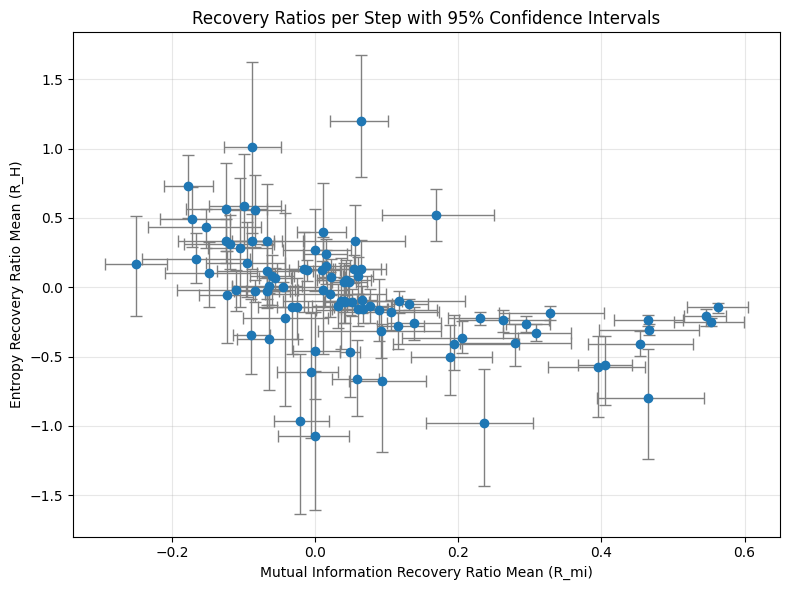

In [ ]:
master_df = pd.read_csv('../src/save_1/ER_dense_base/combined_metrics.csv')  # Assuming the CSV has a 'step' column

results_by_step_dense_base = analyze_network_by_step(master_df)
rr_df_dense_base = recovery_ratios_to_df(results_by_step_dense_base)
filtered_rr_df_dense_base = filter_by_ci_width(rr_df_dense_base)

print("Ratio filtered rr: {}".format(len(filtered_rr_df_dense_base)/ len(rr_df_dense_base)))
# Example usage:


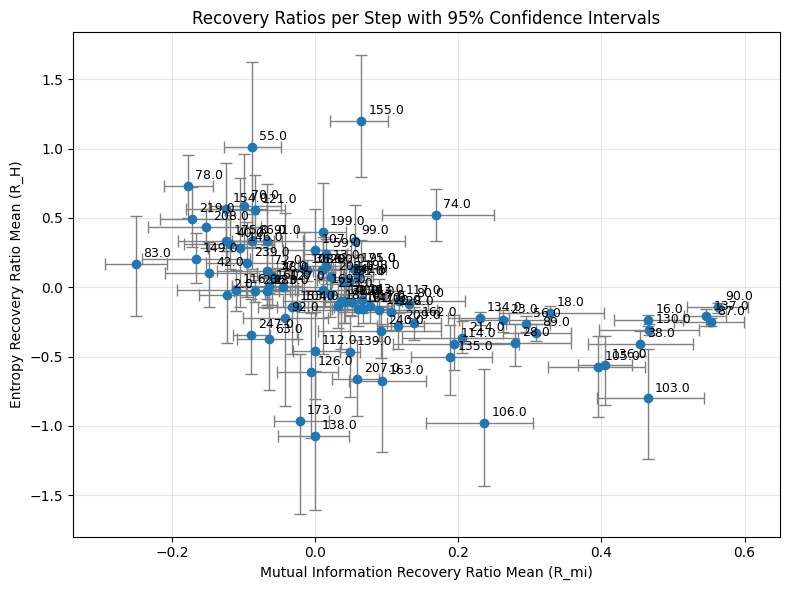

In [57]:
plot_recovery_ratios(filtered_rr_df_dense_base)


In [43]:
master_df = pd.read_csv('../src/save_1/ER_dense_stdp/combined_metrics.csv')  # Assuming the CSV has a 'step' column

results_by_step_dense_stdp = analyze_network_by_step(master_df)
rr_df_dense_stdp = recovery_ratios_to_df(results_by_step_dense_stdp)
filtered_rr_df_dense_stdp = filter_by_ci_width(rr_df_dense_stdp)

print("Ratio filtered rr: {}".format(len(filtered_rr_df_dense_stdp)/ len(rr_df_dense_stdp)))
# Example usage:


100%|██████████| 250/250 [01:00<00:00,  4.14it/s]

Ratio filtered rr: 0.256


In [61]:
rr_df_dense_stdp = recovery_ratios_to_df(results_by_step_dense_stdp)
filtered_rr_df_dense_stdp = filter_by_ci_width(rr_df_dense_stdp)
print("Ratio filtered rr: {}".format(len(filtered_rr_df_dense_stdp)/ len(rr_df_dense_stdp)))


Ratio filtered rr: 0.256


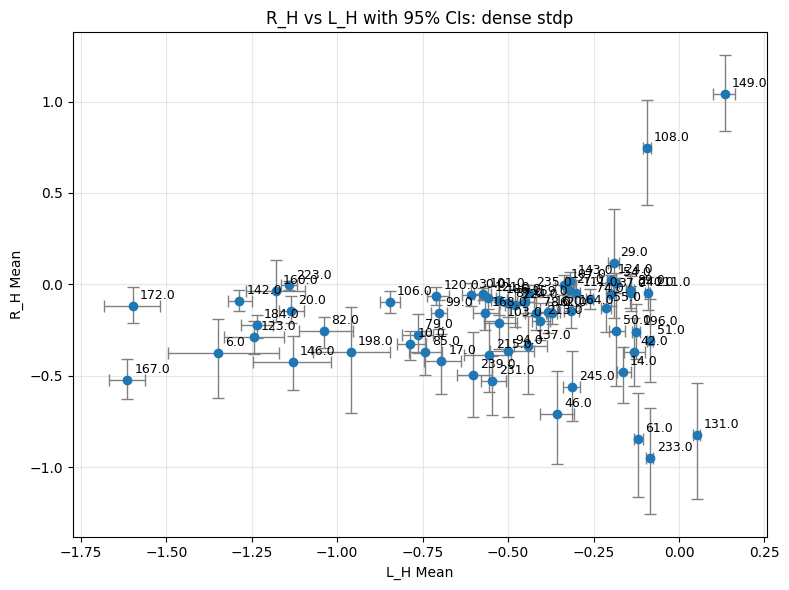

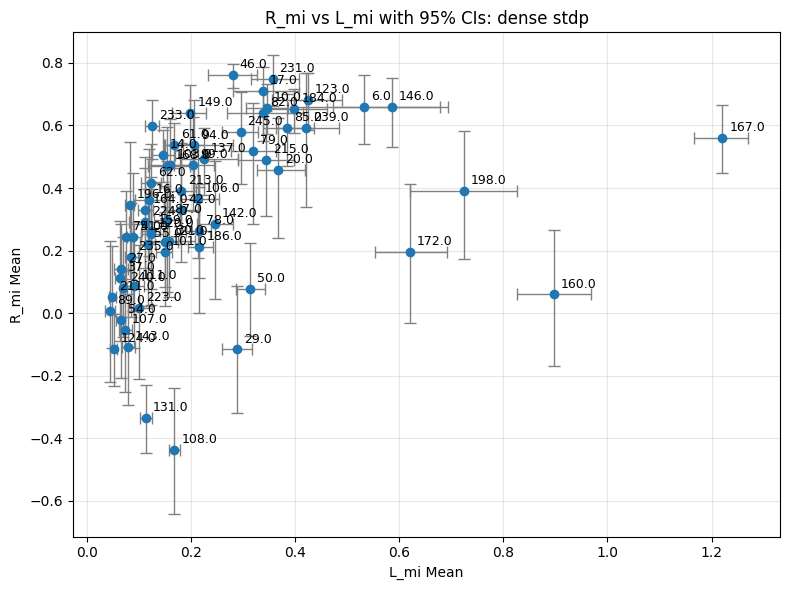

In [68]:
plot_recovery_ratios(filtered_rr_df_dense_stdp, x_var='L_H', y_var='R_H', cat='dense stdp' )
plot_recovery_ratios(filtered_rr_df_dense_stdp, x_var='L_mi', y_var='R_mi', cat='dense stdp' )



In [78]:
master_df = pd.read_csv('../src/save_1/ER_dense_stdp/combined_metrics.csv')  # Assuming the CSV has a 'step' column

master_df[master_df['step'] == 149]

,batch,emsrs_h_A,emsrs_h_B,emsrs_h_C,emsrs_h_A_T,emsrs_h_B_T,emsrs_h_C_T,emsrs_mi_AB,emsrs_mi_AC,emsrs_mi_AA,emsrs_mi_AB_T,emsrs_mi_AC_T,emsrs_mi_AA_T,lz_avg_lz_pre,lz_avg_lz_post_init,lz_avg_lz_post_final,drf_batch_driver_fraction,step
1490,0,12.014917,11.968187,12.040567,9.533526,9.533526,9.533526,11.895708,11.968088,12.014917,9.533526,9.533526,9.533526,0.085295,0.083324,0.082396,0.127602,149
1491,1,12.024911,11.865530,12.028177,9.533526,9.533526,9.533526,11.803044,11.965691,12.024911,9.533526,9.533526,9.533526,0.084683,0.083210,0.081975,0.126356,149
1492,2,12.017953,11.866491,12.042247,9.533526,9.533526,9.533526,11.797047,11.972804,12.017953,9.533526,9.533526,9.533526,0.084702,0.083363,0.082530,0.126739,149
1493,3,12.015895,11.863915,11.946936,9.533526,9.533526,9.533526,11.793444,11.875434,12.015895,9.533526,9.533526,9.533526,0.084415,0.081908,0.084032,0.127834,149
1494,4,12.016913,11.821947,11.980234,9.533526,9.533526,9.533526,11.751463,11.909750,12.016913,9.533526,9.533526,9.533526,0.085085,0.082081,0.084300,0.129142,149
1495,5,12.025456,11.841422,12.047431,9.533526,9.533526,9.533526,11.779482,11.985490,12.025456,9.533526,9.533526,9.533526,0.085133,0.082396,0.081880,0.127804,149
1496,6,12.034460,11.996492,12.056219,9.533526,9.533526,9.533526,11.943556,12.003282,12.034460,9.533526,9.533526,9.533526,0.086558,0.084386,0.081679,0.128461,149
1497,7,12.031990,11.933293,12.040808,9.533526,9.533526,9.533526,11.877886,11.985401,12.031990,9.533526,9.533526,9.533526,0.085630,0.083353,0.081908,0.127775,149
1498,8,12.018327,11.868808,11.949881,9.533526,9.533526,9.533526,11.800770,11.880811,12.018327,9.533526,9.533526,9.533526,0.084654,0.082396,0.085171,0.128979,149
1499,9,12.027432,11.856749,12.025656,9.533526,9.533526,9.533526,11.796784,11.965691,12.027432,9.533526,9.533526,9.533526,0.085094,0.082559,0.084090,0.128337,149


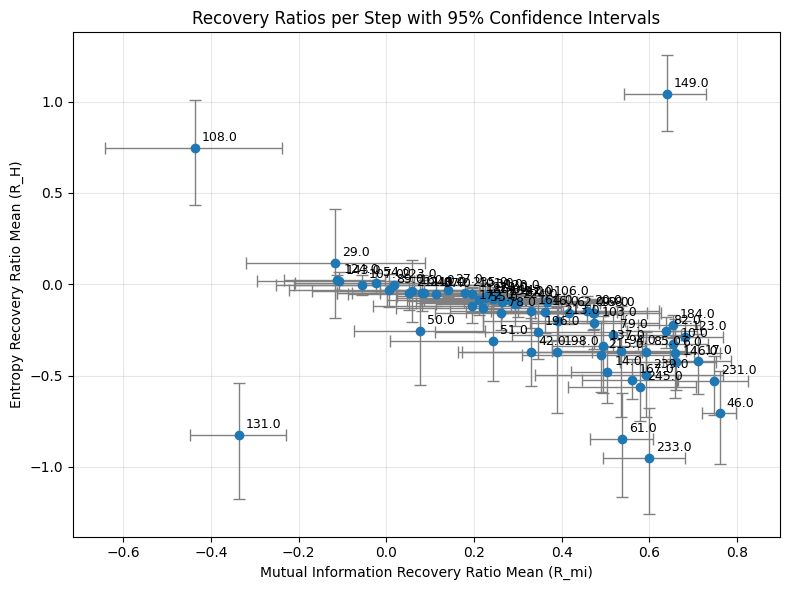

In [ ]:

plot_recovery_ratios(filtered_rr_df_dense_stdp, cat='')


In [ ]:
master_df = pd.read_csv('../src/save_1/ER_intermediate_base/combined_metrics.csv')  # Assuming the CSV has a 'step' column

results_by_step_intermediate_base = analyze_network_by_step(master_df)
rr_df_intermediate_base = recovery_ratios_to_df(results_by_step_sparse_base)
filtered_rr_df_sparse_base = filter_by_ci_width(rr_df_intermediate_base)

print("Ratio filtered rr: {}".format(len(filtered_rr_df_intermediate_base)/ len(rr_df_intermediate_base)))
# Example usage:


100%|██████████| 250/250 [01:01<00:00,  4.07it/s]

Ratio filtered rr: 0.268


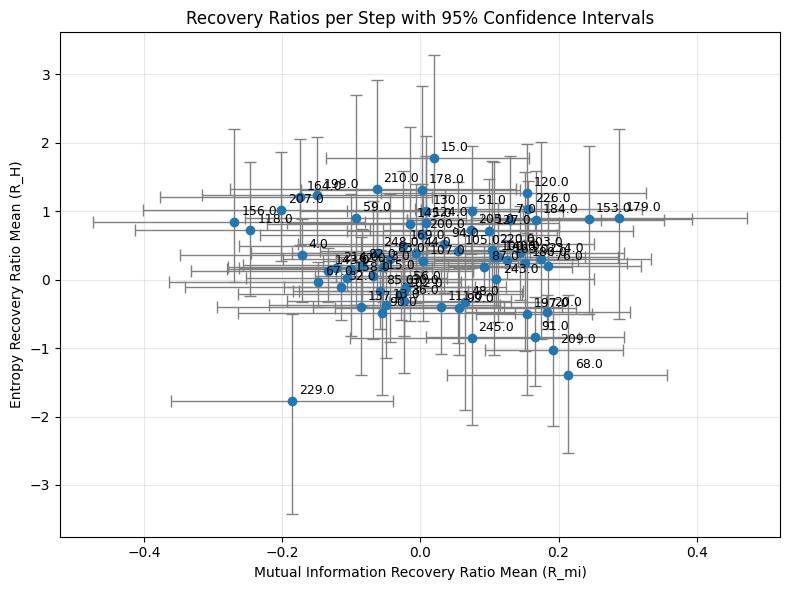

In [48]:
plot_recovery_ratios(filtered_rr_df_intermediate_base)


In [51]:
master_df = pd.read_csv('../src/save_1/ER_intermediate_stdp/combined_metrics.csv')  # Assuming the CSV has a 'step' column

results_by_step_intermediate_stdp = analyze_network_by_step(master_df)
rr_df_intermediate_stdp = recovery_ratios_to_df(results_by_step_intermediate_stdp)
filtered_rr_df_intermediate_stdp = filter_by_ci_width(rr_df_intermediate_stdp)

print("Ratio filtered rr: {}".format(len(filtered_rr_df_intermediate_stdp)/ len(rr_df_intermediate_stdp)))
# Example usage:


100%|██████████| 250/250 [01:01<00:00,  4.08it/s]

Ratio filtered rr: 0.284


In [74]:
results_by_step_intermediate_stdp[149]

{'entropy_stats': {'pre_attack': {'mean': np.float64(11.985762519415111),
   'std': np.float64(0.01384434192465325),
   'min': np.float64(11.960090212873512),
   'max': np.float64(12.00561677017004)},
  'post_immediate': {'mean': np.float64(12.018628336919733),
   'std': np.float64(0.01563116784635937),
   'min': np.float64(11.998141967612264),
   'max': np.float64(12.04356315624692)},
  'post_late': {'mean': np.float64(12.017110361846088),
   'std': np.float64(0.022840883607612123),
   'min': np.float64(11.975393426249044),
   'max': np.float64(12.059042082039856)}},
 'mi_stats': {'AB': {'mean': np.float64(11.916994359341688),
   'std': np.float64(0.020728472267312968),
   'min': np.float64(11.8914192573523),
   'max': np.float64(11.946075536158755)},
  'AC': {'mean': np.float64(11.915476384268043),
   'std': np.float64(0.030983799745269817),
   'min': np.float64(11.861619180867413),
   'max': np.float64(11.964633485385397)},
  'AA': {'mean': np.float64(11.985762519415111),
   'std': 

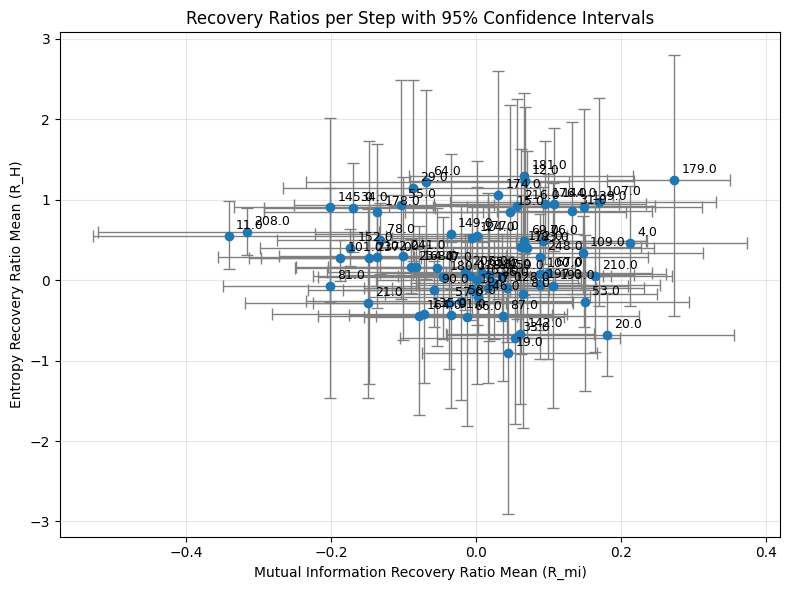

In [52]:
plot_recovery_ratios(filtered_rr_df_intermediate_stdp)


In [54]:
master_df = pd.read_csv('../src/save_1/ER_sparse_base/combined_metrics.csv')  # Assuming the CSV has a 'step' column

results_by_step_sparse_base = analyze_network_by_step(master_df)
rr_df_sparse_base = recovery_ratios_to_df(results_by_step_sparse_base)
filtered_rr_df_sparse_base = filter_by_ci_width(rr_df_sparse_base)

print("Ratio filtered rr: {}".format(len(filtered_rr_df_sparse_base)/ len(rr_df_sparse_base)))

100%|██████████| 250/250 [01:01<00:00,  4.10it/s]

Ratio filtered rr: 0.244


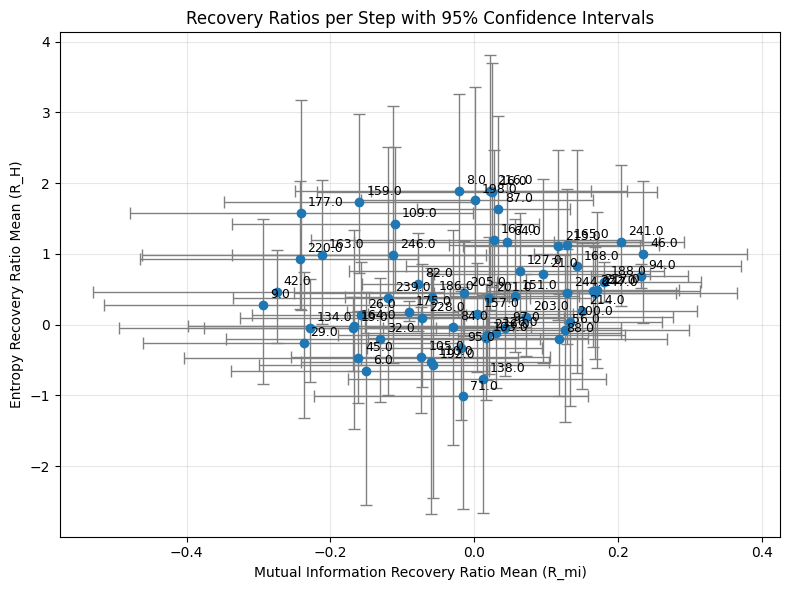

In [55]:
plot_recovery_ratios(filtered_rr_df_sparse_base)


In [53]:
master_df = pd.read_csv('../src/save_1/ER_sparse_stdp/combined_metrics.csv')  # Assuming the CSV has a 'step' column

results_by_step_sparse_stdp = analyze_network_by_step(master_df)
rr_df_sparse_stdp = recovery_ratios_to_df(results_by_step_sparse_stdp)
filtered_rr_df_sparse_stdp = filter_by_ci_width(rr_df_sparse_stdp)

print("Ratio filtered rr: {}".format(len(filtered_rr_df_sparse_stdp)/ len(rr_df_sparse_stdp)))
# Example usage:

100%|██████████| 250/250 [01:03<00:00,  3.96it/s]


Ratio filtered rr: 0.268


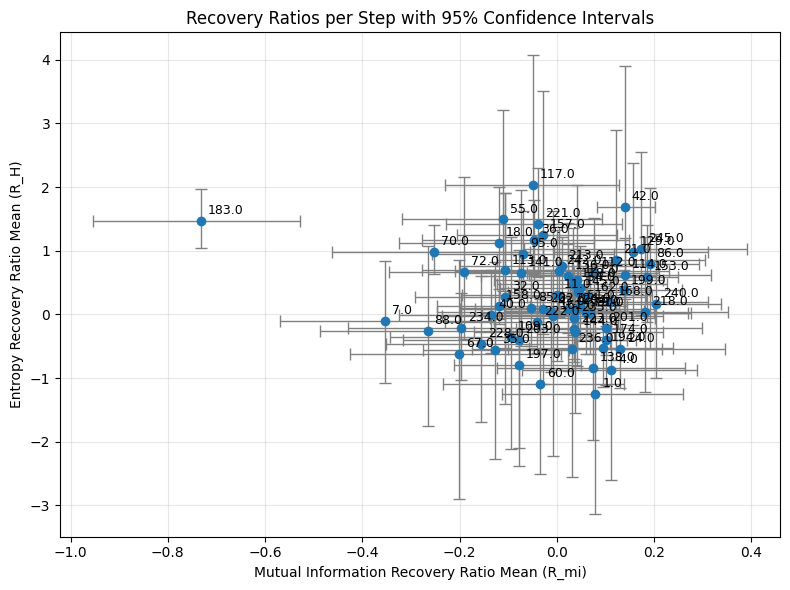

In [56]:
plot_recovery_ratios(filtered_rr_df_sparse_stdp)
